In [1]:
try:
    %matplotlib inline
    %config InlineBackend.figure_format='retina'
except:
    pass

import numpy as np
from astropy.table import Table, join
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from scipy.spatial import cKDTree
import os
import sys

In [2]:
initial_values = Table.read('../spectrum_analysis/galah_dr4_initial_parameters_220714_lite.fits')

In [3]:
grids = Table.read('galah_dr4_model_trainingset_gridpoints.fits')

In [4]:
grids['model_name'] = np.array([str(int(grid['teff_subgrid']))+'_'+str("{:.2f}".format(grid['logg_subgrid']))+'_'+str("{:.2f}".format(grid['fe_h_subgrid'])) for grid in grids])

In [5]:
grid_index_tree = cKDTree(np.c_[grids['teff_subgrid']/1000.,grids['logg_subgrid'],grids['fe_h_subgrid']])

In [6]:
initial_values['grid_index'] = np.array([grid_index_tree.query([tgf[0]/1000.,tgf[1],tgf[2]]) for tgf in np.array([initial_values['teff'],initial_values['logg'],initial_values['fe_h']]).T])[:,1]

In [7]:
indices = initial_values['grid_index']
priority = Table()
d,c = np.unique(indices, return_counts=True)
priority['index_subgrid'] = np.array(d,dtype=int)
priority['counts_dr4_init'] = np.array(c,dtype=int)
priority = join(priority, grids, keys='index_subgrid')
priority.sort(keys='counts_dr4_init',reverse=True)

In [8]:
def test_grid_index_computations(test_grid_index = 1931, print_all_points=False,):
    if print_all_points:
        print('Printing grid points not yet computed for '+str(grids['model_name'][test_grid_index])+':')

    # Find upper and lower Teff points
    test_grid_teff = int(grids['teff_subgrid'][test_grid_index])
    if test_grid_teff <= 4000:
        test_grid_teff_lower = test_grid_teff - 100
    else:
        test_grid_teff_lower = test_grid_teff - 250
    if test_grid_teff <= 3900:
        test_grid_teff_higher = test_grid_teff + 100
    else:
        test_grid_teff_higher = test_grid_teff + 250

    # Find upper and lower logg points
    test_grid_logg = grids['logg_subgrid'][test_grid_index]
    test_grid_logg_lower = test_grid_logg - 0.5
    test_grid_logg_higher = test_grid_logg + 0.5

    # Find upper and lower fe_h points
    test_grid_fe_h = grids['fe_h_subgrid'][test_grid_index]
    if test_grid_fe_h <= -0.75:
        test_grid_fe_h_lower = test_grid_fe_h - 0.5
    else:
        test_grid_fe_h_lower = test_grid_fe_h - 0.25
    if test_grid_fe_h <= -1.5:
        test_grid_fe_h_higher = test_grid_fe_h + 0.5
    else:
        test_grid_fe_h_higher = test_grid_fe_h + 0.25

    for teff in [test_grid_teff_lower,test_grid_teff,test_grid_teff_higher]:
        for logg in [test_grid_logg_lower,test_grid_logg,test_grid_logg_higher]:
            for fe_h in [test_grid_fe_h_lower,test_grid_fe_h,test_grid_fe_h_higher]:
                t = grids['index_subgrid'][grids['model_name'] == str(int(teff))+'_'+"{:.2f}".format(logg)+'_'+"{:.2f}".format(fe_h)]
                if len(t) > 0:
                    if t[0] not in grids_done:
                        if t[0] not in grids_started:
                            if print_all_points:
                                print(t[0],str(int(teff))+'_'+"{:.2f}".format(logg)+'_'+"{:.2f}".format(fe_h))
                            else:
                                print(str(t[0])+',')
                        else:
                            if print_all_points:
                                print(t[0],str(int(teff))+'_'+"{:.2f}".format(logg)+'_'+"{:.2f}".format(fe_h), 'already started')
                    else:
                        if print_all_points:
                            print(t[0],str(int(teff))+'_'+"{:.2f}".format(logg)+'_'+"{:.2f}".format(fe_h), 'already done')
                else:
                    if print_all_points:
                        print('Not in GRID :', str(int(teff))+'_'+"{:.2f}".format(logg)+'_'+"{:.2f}".format(fe_h))
                    

In [9]:
def test_grid_index_ready_for_training(test_grid_index = 1931, print_all_points=False,):
    if print_all_points:
        print('Printing grid points not yet computed for '+str(grids['model_name'][test_grid_index])+':')

    # Find upper and lower Teff points
    test_grid_teff = int(grids['teff_subgrid'][test_grid_index])
    if test_grid_teff <= 4000:
        test_grid_teff_lower = test_grid_teff - 100
    else:
        test_grid_teff_lower = test_grid_teff - 250
    if test_grid_teff <= 3900:
        test_grid_teff_higher = test_grid_teff + 100
    else:
        test_grid_teff_higher = test_grid_teff + 250

    # Find upper and lower logg points
    test_grid_logg = grids['logg_subgrid'][test_grid_index]
    test_grid_logg_lower = test_grid_logg - 0.5
    test_grid_logg_higher = test_grid_logg + 0.5

    # Find upper and lower fe_h points
    test_grid_fe_h = grids['fe_h_subgrid'][test_grid_index]
    if test_grid_fe_h <= -0.75:
        test_grid_fe_h_lower = test_grid_fe_h - 0.5
    else:
        test_grid_fe_h_lower = test_grid_fe_h - 0.25
    if test_grid_fe_h <= -1.5:
        test_grid_fe_h_higher = test_grid_fe_h + 0.5
    else:
        test_grid_fe_h_higher = test_grid_fe_h + 0.25

    for teff in [test_grid_teff_lower,test_grid_teff,test_grid_teff_higher]:
        for logg in [test_grid_logg_lower,test_grid_logg,test_grid_logg_higher]:
            for fe_h in [test_grid_fe_h_lower,test_grid_fe_h,test_grid_fe_h_higher]:
                t = grids['index_subgrid'][grids['model_name'] == str(int(teff))+'_'+"{:.2f}".format(logg)+'_'+"{:.2f}".format(fe_h)]
                if len(t) > 0:
                    if t[0] not in grids_converted_to_nn_input:
                        print(t[0],str(int(teff))+'_'+"{:.2f}".format(logg)+'_'+"{:.2f}".format(fe_h),' not ready')
                    else:
                        print(t[0],str(int(teff))+'_'+"{:.2f}".format(logg)+'_'+"{:.2f}".format(fe_h),' done')
                else:
                    if print_all_points:
                        print('Not in GRID :', str(int(teff))+'_'+"{:.2f}".format(logg)+'_'+"{:.2f}".format(fe_h))
                    

In [21]:
def test_progress():
    
    number_points_calculated_all = []
    number_points_needed_all = []
    
    for test_grid_index in grids['index_subgrid']:#[grids_converted_to_nn_input]:

        # Find upper and lower Teff points
        test_grid_teff = int(grids['teff_subgrid'][test_grid_index])
        if test_grid_teff <= 4000:
            test_grid_teff_lower = test_grid_teff - 100
        else:
            test_grid_teff_lower = test_grid_teff - 250
        if test_grid_teff <= 3900:
            test_grid_teff_higher = test_grid_teff + 100
        else:
            test_grid_teff_higher = test_grid_teff + 250

        # Find upper and lower logg points
        test_grid_logg = grids['logg_subgrid'][test_grid_index]
        test_grid_logg_lower = test_grid_logg - 0.5
        test_grid_logg_higher = test_grid_logg + 0.5

        # Find upper and lower fe_h points
        test_grid_fe_h = grids['fe_h_subgrid'][test_grid_index]
        if test_grid_fe_h <= -0.75:
            test_grid_fe_h_lower = test_grid_fe_h - 0.5
        else:
            test_grid_fe_h_lower = test_grid_fe_h - 0.25
        if test_grid_fe_h <= -1.5:
            test_grid_fe_h_higher = test_grid_fe_h + 0.5
        else:
            test_grid_fe_h_higher = test_grid_fe_h + 0.25

        number_points_calculated_each = 0
        number_points_needed_each = 0
        next_needed = None
        
        for teff in [test_grid_teff_lower,test_grid_teff,test_grid_teff_higher]:
            for logg in [test_grid_logg_lower,test_grid_logg,test_grid_logg_higher]:
                for fe_h in [test_grid_fe_h_lower,test_grid_fe_h,test_grid_fe_h_higher]:
                    
                    t = grids['index_subgrid'][grids['model_name'] == str(int(teff))+'_'+"{:.2f}".format(logg)+'_'+"{:.2f}".format(fe_h)]
                    
                    if len(t) > 0:
                        number_points_needed_each += 1
                        if t[0] in grids_converted_to_nn_input:
                            number_points_calculated_each += 1
                        else:
                            next_needed = t[0]
                    else:
                        # there is no grid point for this one.
                        pass

        number_points_calculated_all.append(number_points_calculated_each)
        number_points_needed_all.append(number_points_needed_each)
        
        try:
            counts = priority['counts_dr4_init'][priority['index_subgrid']==test_grid_index][0]
            if counts < 10:
                counts = str(counts)+'    '
            elif counts < 100:
                counts = str(counts)+'   '
            elif counts < 1000:
                counts = str(counts)+'  '
            elif counts < 10000:
                counts = str(counts)+' '
            else:
                counts = str(counts)
        except:
            counts = 'none '

        if number_points_calculated_each == number_points_needed_each:
            if test_grid_index in trained_3x3x3:
                pass
                # print(str(test_grid_index)+' trained 3x3x3')
            else:
                print(str(test_grid_index)+' '+counts+'  -----------------------------------------------------      TRAIN!!!')
        elif number_points_calculated_each > number_points_needed_each - 7:
            if next_needed in grids_done:
                print(str(test_grid_index)+' '+counts+' only '+str(number_points_needed_each - number_points_calculated_each)+' more:', next_needed, '                             CONVERT')
            elif next_needed in grids_started:
                print(str(test_grid_index)+' '+counts+' only '+str(number_points_needed_each - number_points_calculated_each)+' more:', next_needed, '                PBS running')
            else:
                print(str(test_grid_index)+' '+counts+' only '+str(number_points_needed_each - number_points_calculated_each)+' more:', next_needed, ' Submit to PBS!')

In [47]:
grids_started = [
1120,
1132,
1246,
1258,
1270,
1485,
1486,
1497,
1498,
1509,
1510,
1552,
1621,
1622,
1623,
1722,
1793,
1805,
1817,
1893,
1894,
1895,
1976,
1977,
1978,
2053,
2054,
2055,
]
print(len(grids_started))

28


In [48]:
grids_done = [
    478, # for analysis of 131216001101084
    1109,1110,1111,
    1121,1122,1123,
    1133,1134,1135,
    1231,1232,1233,
    1242,1243,1244,1245,
    1254,1255,1256,1257,
    1266,1267,1268,1269,
    1340,1341,1342,
    1351,1352,1353,1354,1355,
    1363,1364,1365,1366,1367,
    1375,1376,1377,1378,1379,
    1387,1388,1389,1390,
    1446,1447,1448,
    1457,1458,1459,
    1460,1461,
    1469,
    1470,1471,1472,1473,
    1481,1482,1483,1484,
    1493,1494,1495,1496,
    1506,1507,1508,
    1560,1561,1562,1563,
    1572,1573,1574,1575,
    1584,1585,1586,1587,
    1596,1597,1598,1599,
    1609,1610,1611,
    1672,1673,1674,
    1683,1684,1685,1686,
    1695,1696,1697,1698,
    1707,1708,1709,1710,
    1719,1720,1721,
    1724,1725,1726,1727,1728,
    1736,1737,1738,1739,1740,   
    1748,1749,
    1750,1751,1752,
    1790,1791,1792,
    1802,1803,1804,
    1814,1815,1816,
    1819,
    1820,1821,1822,1823,
    1831,1832,1833,1834,1835,
    1843,1844,1845,1846,1847,
    1876,1877,1878,
    1888,1889,
    1890,
    1900,1901,1902,
    1905,1906,1907,1908,1909,
    1917,1918,1919,
    1920,1921,
    1929,
    1930,1931,1932,1933,
    1988,1989,
    1990,1991,1992,
    2000,2001,2002,2003,2004,
    2012,2013,2014,2015,2016,
    2065,2066,2067,2068,2069,
    2077,2078,2079,
    2080,2081,
    2089,
    2090,2091,2092,2093,
]
print(len(grids_done),len(grids_done) * 280)

201 56280


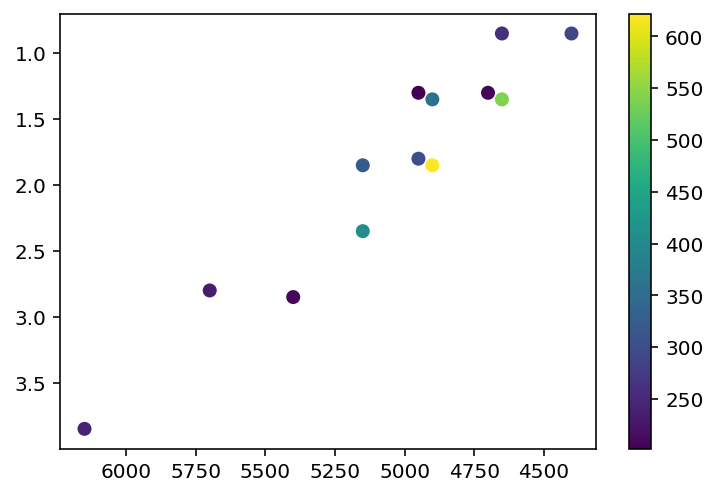

[1483, 1365, 1598, 1471, 1586, 1482, 1244, 1353, 1997, 1803, 1709, 1364, 1470]


index_subgrid,counts_dr4_init,teff_subgrid,teff_low_subgrid,teff_high_subgrid,logg_subgrid,logg_low_subgrid,logg_high_subgrid,fe_h_subgrid,fe_h_low_subgrid,fe_h_high_subgrid,random_seed_subgrid,model_name
int64,int64,float32,float32,float32,float32,float32,float32,float32,float32,float32,int64,str15
1483,622,4750.0,4500.0,5000.0,2.0,1.5,2.5,-1.5,-2.0,-1.0,4620,4750_2.00_-1.50
1365,541,4500.0,4250.0,4750.0,1.5,1.0,2.0,-1.5,-2.0,-1.0,4365,4500_1.50_-1.50
1598,406,5000.0,4750.0,5250.0,2.5,2.0,3.0,-1.5,-2.0,-1.0,4875,5000_2.50_-1.50
1471,360,4750.0,4500.0,5000.0,1.5,1.0,2.0,-1.5,-2.0,-1.0,4615,4750_1.50_-1.50
1586,321,5000.0,4750.0,5250.0,2.0,1.5,2.5,-1.5,-2.0,-1.0,4870,5000_2.00_-1.50
1482,300,4750.0,4500.0,5000.0,2.0,1.5,2.5,-2.0,-2.5,-1.5,4570,4750_2.00_-2.00
1244,290,4250.0,4000.0,4500.0,1.0,0.5,1.5,-1.5,-2.0,-1.0,4110,4250_1.00_-1.50
1353,260,4500.0,4250.0,4750.0,1.0,0.5,1.5,-1.5,-2.0,-1.0,4360,4500_1.00_-1.50
1997,243,6000.0,5750.0,6250.0,4.0,3.5,4.5,-1.5,-2.0,-1.0,5890,6000_4.00_-1.50


In [49]:
selection = (priority['fe_h_subgrid'] <= -2) & (priority['counts_dr4_init'] > 200)
selection = (priority['fe_h_subgrid'] <= -1.5) & (priority['counts_dr4_init'] > 200) & (priority['teff_subgrid'] <= 6000)
# selection = (priority['fe_h_subgrid'] <= -0.75) & (priority['counts_dr4_init'] > 2800)


f, ax = plt.subplots()
s = ax.scatter(
    priority['teff_subgrid'][selection] + np.abs(100*priority['fe_h_subgrid'][selection]),
    priority['logg_subgrid'][selection] + 0.1*priority['fe_h_subgrid'][selection],
    c = priority['counts_dr4_init'][selection],
)
plt.colorbar(s, ax=ax)
ax.set_xlim(ax.get_xlim()[::-1])
ax.set_ylim(ax.get_ylim()[::-1])
plt.show()
plt.close()

print(list(priority['index_subgrid'][selection]))

priority[selection]

In [50]:
# ALREADY DONE
selection = [
    1244,
    1341,
    1353,
    1364,1365,1366,
    1458,
    1470,1471,
    1482,1483,
    1586,
    1598,
#     1600,
    1709,
    1803,
    1832,1833,1834,
    1844,1845,1846,
    1918,1919,1920,
    1930,1931,1932,
    1989,
    2001,2002,2003,
    2013,2014,2015,
]
# selection = []

for t in selection:
    test_grid_index_computations(t)

In [51]:
grids_converted_to_nn_input = [
    478,
    1109,1110,1111,
    1121,1122,1123,
    1133,1134,1135,
    1231,1232,1233,
    1242,1243,1244,1245,
    1254,1255,1256,1257,
    1266,1267,1268,1269,
    1340,1341,1342,
    1351,1352,1353,1354,
    1363,1364,1365,1366,
    1375,1376,1377,1378,
    1387,1388,1389,
    1390,
    1446,1447,1448,
    1457,1458,1459,
    1460,1461,
    1469,
    1470,1471,1472,1473,
    1481,1482,1483,1484,
    1493,1494,1495,1496,
    1506,1507,1508,
    1560,1561,1562,1563,
    1572,1573,1574,1575,
    1584,1585,1586,1587,
    1596,1597,1598,1599,
    1609,
    1610,1611,
    1695,1696,1697,
    1672,1673,1674,
    1683,1684,1685,1686,
    1698,
    1707,1708,1709,
    1710,
    1719,1720,1721,
    1724,1725,1726,1727,1728,
    1736,1737,1738,1739,1740,
    1748,1749,
    1750,1751,1752,
    1790,1791,1792,
    1802,1803,1804,
    1814,1815,1816,
    1819,1820,1821,1822,1823,
    1831,1832,1833,1834,1835,
    1843,1844,1845,1846,1847,
    1876,1877,1878,
    1888,1889,
    1890,
    1900,1901,1902,
    1905,1906,1907,1908,1909,
    1917,1918,1919,
    1920,1921,
    1929,1930,1931,1932,1933,
    1988,1989,1990,1991,1992,
    2000,2001,2002,2003,2004,
    2012,2013,2014,2015,2016,
    2065,2066,2067,2068,2069,
    2077,2078,2079,
    2080,2081,
    2089,
    2090,2091,2092,2093,
]
print(len(grids_converted_to_nn_input))

198


In [69]:
trained_3x3x3 = [
    1232, # Training with 6415 spectra (89%), Testing with 713 spectra (10%), 9033.599 validation loss = 8952.251
    1244, # Training with 11232 spectra (90%), Testing with 1248 spectra (10%), 8918.089 validation loss = 8923.438
# CURRENT GRIDS IN LOOP WITH TRAIN2
#     1340,
#     1341,
    1364, # Training with 9423 spectra (90%), Testing with 1047 spectra (10%), 9559.972 validation loss = 9560.110, 22.216 validation loss = 23.934
    1365, # Training with 10330 spectra (89%), Testing with 1148 spectra (10%), 9244.988 validation loss = 9285.615
    1470, # Training with 9915 spectra (89%), Testing with 1102 spectra (10%), 9699.579 validation loss = 9660.728
    1471, # Training with 10410 spectra (89%), Testing with 1157 spectra (10%), 9457.726 validation loss = 9459.764
    1482, # Training with 10002 spectra (89%), Testing with 1112 spectra (10%), 9663.655 validation loss = 9652.573,
    1483, # Training with 10544 spectra (89%), Testing with 1172 spectra (10%), 9465.517 validation loss = 9439.481, 25.909 validation loss = 26.766
# CURRENT GRIDS IN LOOP WITH TRAIN
#     1352,
#     1353,
    1586, # Training with 11475 spectra (90%), Testing with 1275 spectra (10%), 9513.832 validation loss = 9504.287
# CURRENT GRIDS IN LOOP WITH TRAIN
#     1598,
    1803,
    1832,1833,1834,
    1844,1845,1846,
    1918,
    1919,
    1920, # Training with 10884 spectra (89%), Testing with 1210 spectra (10%), 8908.265 validation loss = 8927.847
    1930, # Training with 8631 spectra (90%), Testing with 959 spectra (10%), 9365.203 validation loss = 9314.398
    1931,
    1932, # Training with 8355 spectra (89%), Testing with 929 spectra (10%), 8988.107 validation loss = 8910.192, 35.799 validation loss = 39.891
    2001, # Training with 12441 spectra (89%), Testing with 1383 spectra (10%), 9266.918 validation loss = 9256.894, 21.200 validation loss = 21.490
    2002,
    2003, # Training with 11946 spectra (89%), Testing with 1328 spectra (10%), 9006.185 validation loss = 8993.563,
    2013, # Training with 9369 spectra (90%), Testing with 1041 spectra (10%), 9359.681 validation loss = 9390.210
    2014, # Training with 9301 spectra (89%), Testing with 1034 spectra (10%), 9220.544 validation loss = 9255.023
    2015, # Training with 9162 spectra (90%), Testing with 1018 spectra (10%), 9057.569 validation loss = 9055.459,
]

# Currently running:
# Train1: 1352,1353,1598
# Train2: 1340,1341

print('Trained 3x3x3 for '+str(len(trained_3x3x3)))

raise ValueError('Not running testing training progress script')
print('Updating galah_dr4_model_trainingset_gridpoints_trained.fits!')
os.system('ipython galah_dr4_model_trainingset_gridpoints_test_training.py');
print('Updated')

Trained 3x3x3 for 28
Updating galah_dr4_model_trainingset_gridpoints_trained.fits!
Updated


In [63]:
s = []
for grid_p in grids_done:
    if grid_p not in grids_converted_to_nn_input:
        print(str(grid_p)+',')
        s.append(grid_p)
print(len(s))
print('import os')
print('ps = ['+','.join([str(x) for x in s])+']')
print('for p in ps:')
print("    os.system('ipython galah_dr4_grid_interpolation_trainingset_creation.py '+str(p))")

1355,
1367,
1379,
3
import os
ps = [1355,1367,1379]
for p in ps:
    os.system('ipython galah_dr4_grid_interpolation_trainingset_creation.py '+str(p))


In [64]:
# Currently converting
# t1: none
# t3: 1355

In [68]:
test_progress()

1109 2     only 6 more: 1120                 PBS running
1110 21    only 6 more: 1000  Submit to PBS!
1231 39    only 1 more: 1120                 PBS running
1233 30    only 6 more: 1355                              CONVERT
1243 80    only 2 more: 1132                 PBS running
1255 14    only 5 more: 1146  Submit to PBS!
1256 37    only 3 more: 1147  Submit to PBS!
1340 7      ---------------------------------------------------------------      TRAIN!!!
1341 5      ---------------------------------------------------------------      TRAIN!!!
1342 7     only 5 more: 1449  Submit to PBS!
1350 none  only 6 more: 1468  Submit to PBS!
1351 none  only 6 more: 1468  Submit to PBS!
1352 172    ---------------------------------------------------------------      TRAIN!!!
1353 260    ---------------------------------------------------------------      TRAIN!!!
1376 32    only 3 more: 1280  Submit to PBS!
1377 54    only 3 more: 1281  Submit to PBS!
1446 none  only 1 more: 1552               

In [66]:
grids[1989]

index_subgrid,teff_subgrid,teff_low_subgrid,teff_high_subgrid,logg_subgrid,logg_low_subgrid,logg_high_subgrid,fe_h_subgrid,fe_h_low_subgrid,fe_h_high_subgrid,random_seed_subgrid,model_name
int64,float32,float32,float32,float32,float32,float32,float32,float32,float32,int64,str15
1989,6000.0,5750.0,6250.0,3.5,3.0,4.0,-0.25,-0.5,0.0,6010,6000_3.50_-0.25


In [67]:
for s in [1989]: # 1341,1353,1366,1458,  # 6000_3.50_-0.25
    test_grid_index_ready_for_training(test_grid_index = s)
    # ready:
    # 1232,
    # 1364,1365,
    # 1470,1471,
    # 1482,1483,
    # 1586,
    # 1832,1833,1834,
    # 1844,1845,1846,
    # 1918,1919,1920,
    # 1930,1931,1932,
    # 2001,2002,2003,
    # 2013,2014,2015
    
    # not yet ready: 1458 because of 1340,1341,1446,1447,1552

1893 5750_3.00_-0.50  not ready
1894 5750_3.00_-0.25  not ready
1895 5750_3.00_0.00  not ready
1905 5750_3.50_-0.50  done
1906 5750_3.50_-0.25  done
1907 5750_3.50_0.00  done
1917 5750_4.00_-0.50  done
1918 5750_4.00_-0.25  done
1919 5750_4.00_0.00  done
1976 6000_3.00_-0.50  not ready
1977 6000_3.00_-0.25  not ready
1978 6000_3.00_0.00  not ready
1988 6000_3.50_-0.50  done
1989 6000_3.50_-0.25  done
1990 6000_3.50_0.00  done
2000 6000_4.00_-0.50  done
2001 6000_4.00_-0.25  done
2002 6000_4.00_0.00  done
2053 6250_3.00_-0.50  not ready
2054 6250_3.00_-0.25  not ready
2055 6250_3.00_0.00  not ready
2065 6250_3.50_-0.50  done
2066 6250_3.50_-0.25  done
2067 6250_3.50_0.00  done
2077 6250_4.00_-0.50  done
2078 6250_4.00_-0.25  done
2079 6250_4.00_0.00  done
